In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#download the latest version of transformer from github
!pip install git+https://github.com/huggingface/transformers.git@main

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-6t1pzdx0
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-6t1pzdx0
  Resolved https://github.com/huggingface/transformers.git to commit 3335724376319a0c453049d0cd883504f530ff52
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#import the datasets module for acquiring the fintuning dataset
!pip install -q datasets

In [ ]:
#send the usage data to hugging face
from transformers.utils import send_example_telemetry

send_example_telemetry("image_captioning_blip_notebook", framework="pytorch")

In [ ]:
#load a sample dataset from the datasets module
from datasets import load_dataset
dataset = load_dataset("ybelkada/football-dataset", split="train")

In [ ]:
#retrieve the caption of the first example
print(dataset)
dataset[0]['text']
#dataset[0]['image']

Dataset({
    features: ['image', 'text'],
    num_rows: 6
})


"Benzema after Real Mardid's win against PSG"

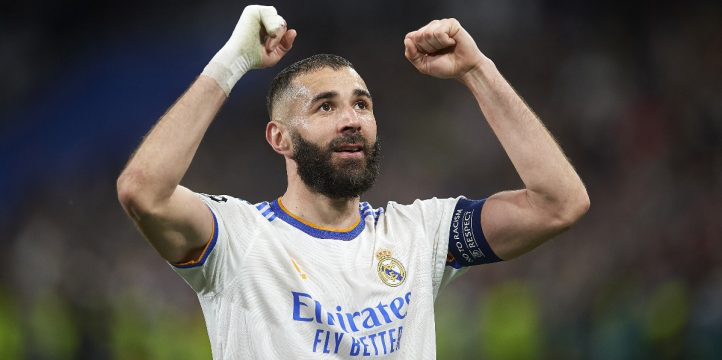

In [ ]:
#retreive the image of the first sample in the dataset
dataset[0]['image']

In [ ]:
#create a image caption dataset class to specifically process the input data for the image caption tasks
from torch.utils.data import Dataset,DataLoader
class ImageCaptioningDataset(Dataset):
  def __init__(self,dataset,processor):
    self.dataset=dataset
    self.processor=processor
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    item=self.dataset[idx]
    encoding=self.processor(images=item['image'],text=item['text'],padding='max_length',return_tensors='pt')
    encoding={k:v.squeeze() for k,v in encoding.items()}
    return encoding

In [ ]:
#load the model and processor
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

RuntimeError: ignored

In [ ]:
#view the inside architecture of the model
print(model)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [ ]:
#load the dataset and dataloader
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)
print(len(train_dataset))
print(dataset[1])

6
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1800x1800 at 0x7F251F8F9990>, 'text': 'Maradona after winning the 1986 FIFA World Cup with Argentina'}


In [ ]:
#train the model based on the given dataset
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

def train_1(num_epochs,model,data_loader,optimizer):
  train_loss_lst=[]
  for epoch in range(num_epochs):
    print("Epoch:", epoch)
    epoch_loss=0
    for idx, batch in enumerate(train_dataloader):
      input_ids = batch.pop("input_ids").to(device)
      pixel_values = batch.pop("pixel_values").to(device)

      outputs = model(input_ids=input_ids,
                      pixel_values=pixel_values,
                      labels=input_ids)
      
      loss = outputs.loss

      print("Loss:", loss.item())

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      epoch_loss+=loss
    train_loss_lst.append(epoch_loss)
  return train_loss_lst

In [ ]:
train_loss_lst=train_1(num_epochs=50,model=model,data_loader=train_dataloader,optimizer=optimizer)

Epoch: 0
Loss: 13.016937255859375
Loss: 10.2988920211792
Loss: 10.225410461425781
Epoch: 1
Loss: 10.20706844329834
Loss: 10.172646522521973
Loss: 10.180901527404785
Epoch: 2
Loss: 10.140965461730957
Loss: 10.132552146911621
Loss: 10.15924072265625
Epoch: 3
Loss: 10.10019302368164
Loss: 10.122964859008789
Loss: 10.092965126037598
Epoch: 4
Loss: 10.101635932922363
Loss: 10.066242218017578
Loss: 10.053571701049805
Epoch: 5
Loss: 10.05194091796875
Loss: 10.069162368774414
Loss: 9.97823715209961
Epoch: 6
Loss: 10.005709648132324
Loss: 9.942551612854004
Loss: 9.847691535949707
Epoch: 7
Loss: 9.580735206604004
Loss: 9.229879379272461
Loss: 9.020720481872559
Epoch: 8
Loss: 8.771234512329102
Loss: 8.599117279052734
Loss: 8.38407039642334
Epoch: 9
Loss: 8.178963661193848
Loss: 7.991205215454102
Loss: 7.851778507232666
Epoch: 10
Loss: 7.658292770385742
Loss: 7.4601898193359375
Loss: 7.292262554168701
Epoch: 11
Loss: 7.153463840484619
Loss: 6.99997615814209
Loss: 6.845680236816406
Epoch: 12
Loss: 

In [ ]:
#conver the tensor to list
for i in range(len(train_loss_lst)):
  train_loss_lst[i]=train_loss_lst[i].item()
print(train_loss_lst)

In [ ]:
#plot the training error against the training epochs
import matplotlib.pyplot as plt
lst=[i for i in range(50)]
plt.plot(lst,train_loss_lst,label='training loss')
plt.xlabel('Num of Training Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

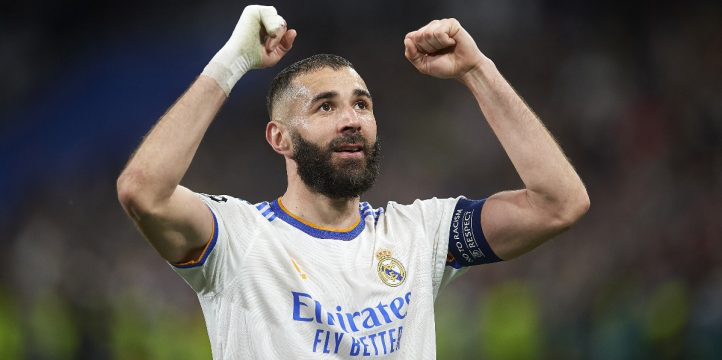

In [ ]:
#choose a example image
example=dataset[0]
image=example['image']
image

In [ ]:
#check out the results for the training dataset
example=dataset[0]
image=example['image']
image
#preapare image for the trained model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

zida in action during the match between real madrid and real madrid


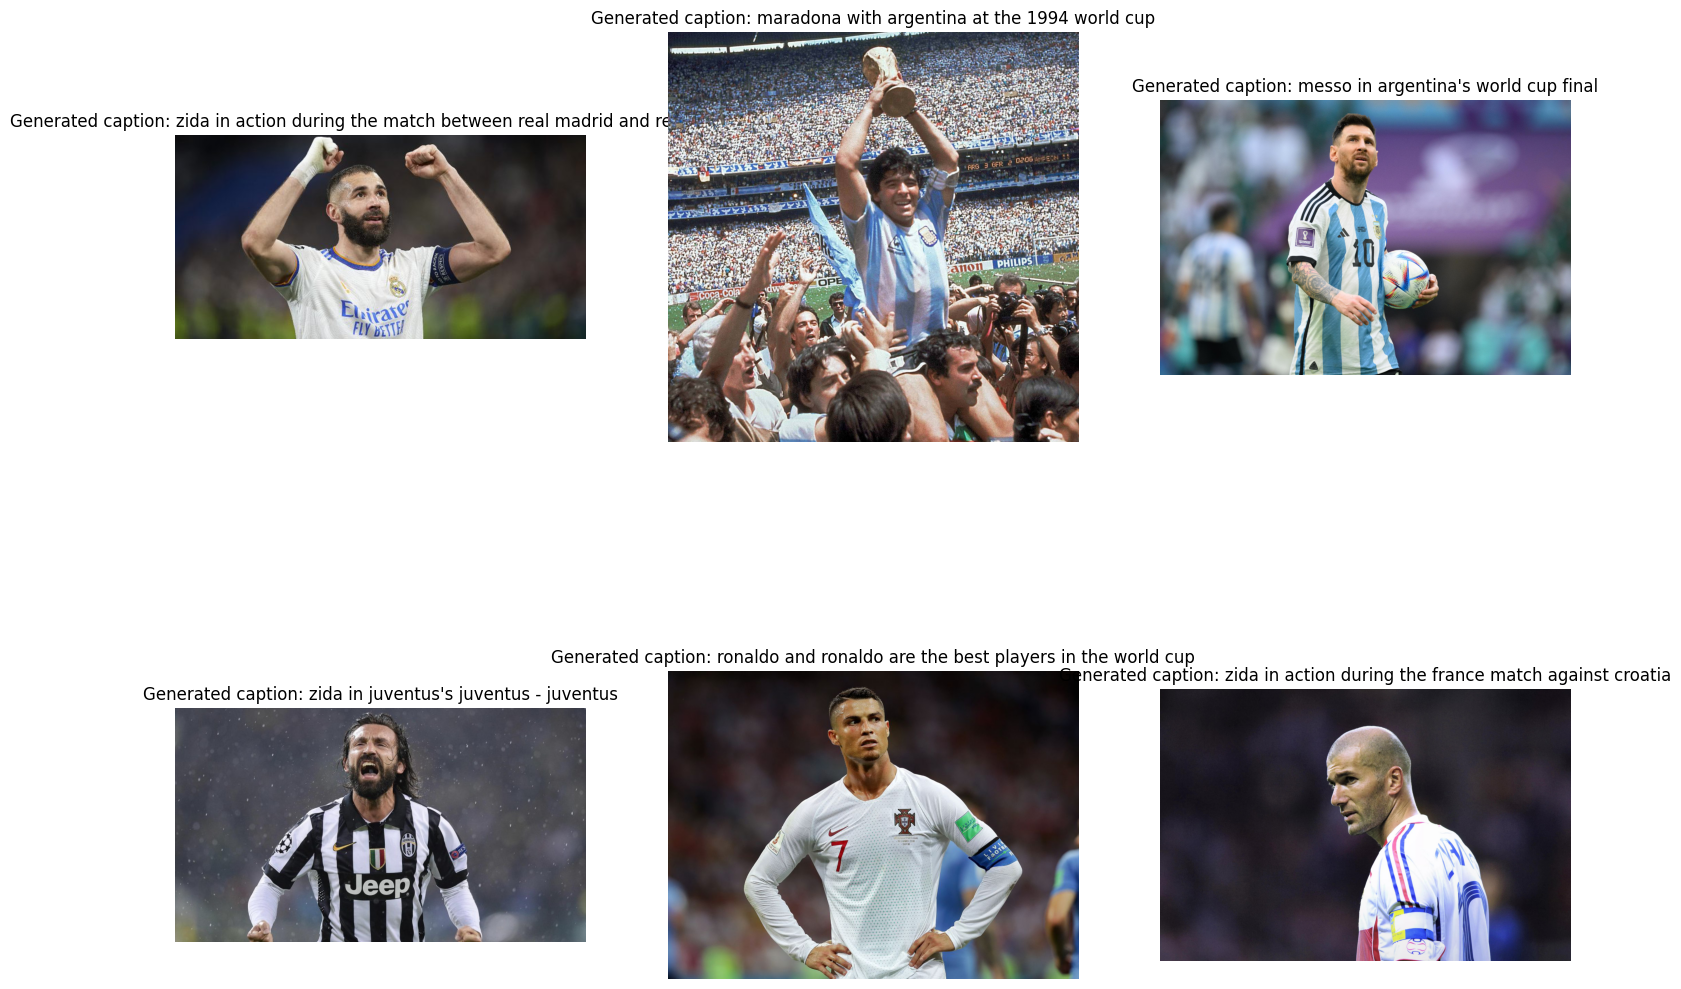

In [ ]:
#test the result on all images in the dataset
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))
#prepare image for the model
for i,example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")


In [ ]:
#lock the parameters in the fintuned model
for param in model.parameters():
  param.required_grad=False

In [ ]:
#save the model on google drive
import os

save_dir='/content/drive/MyDrive/Machine Learning final project/models'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)
torch.save(model,save_dir+'/model.pth')